In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
titanic_data = pd.read_csv('data/train.csv')
print(titanic_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


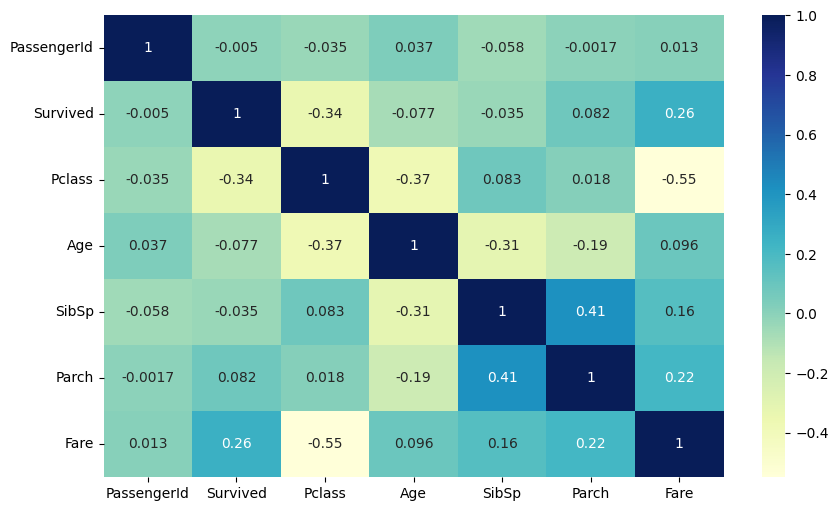

In [7]:
numeric_data = titanic_data.select_dtypes(include=['number'])

# Compute correlation
correlation_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, cmap="YlGnBu",annot=True)
plt.show()

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data["Survived"]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

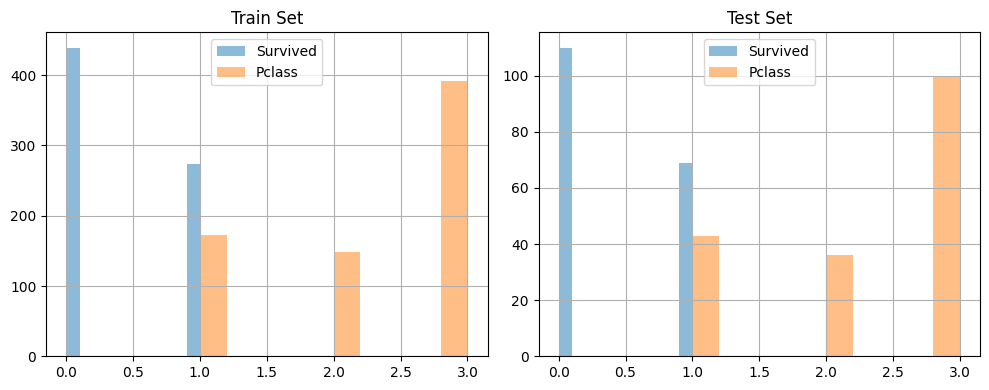

In [11]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
strat_train_set['Survived'].hist(alpha=0.5, label='Survived')
strat_train_set['Pclass'].hist(alpha=0.5, label='Pclass')
plt.legend()
plt.title("Train Set")

plt.subplot(1, 2, 2)
strat_test_set['Survived'].hist(alpha=0.5, label='Survived')
strat_test_set['Pclass'].hist(alpha=0.5, label='Pclass')
plt.legend()
plt.title("Test Set")

plt.tight_layout()
plt.show()

In [13]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 51 to 109
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        162 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X["Age"] = imputer.fit_transform(X[["Age"]])
        return X

In [17]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()

        matrix = encoder.fit_transform(X[["Embarked"]]).toarray()
        column_names = ["C", "S", "Q", "N"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[["Sex"]]).toarray()
        column_names = ["Female", "Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X

In [19]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "Fare"], axis=1, errors="ignore")

In [21]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("ageimputer", AgeImputer()),
    ("featureencoder", FeatureEncoder()),
    ("featuredropper", FeatureDropper())
])

strat_train_set = pipeline.fit_transform(strat_train_set)

In [23]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(["Survived"], axis=1)
y = strat_train_set["Survived"]

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
param_grid = {
    "n_estimators": [10, 100, 200, 500],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 3, 4]
}

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 100, 200, 500]},
             return_train_score=True, scoring='accuracy')

In [27]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(max_depth=5)

In [29]:
strat_test_set = pipeline.fit_transform(strat_test_set)

X_test = strat_test_set.drop(["Survived"], axis=1)
y_test = strat_test_set["Survived"]

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [31]:
final_clf.score(X_data_test,y_data_test)

ValueError: X has 10 features, but RandomForestClassifier is expecting 11 features as input.

In [33]:
# Add any missing feature columns with default value 0
for col in final_clf.feature_names_in_:
    if col not in X_data_test.columns:
        X_data_test[col] = 0

# Reorder columns to match the training data
X_data_test = X_data_test[final_clf.feature_names_in_]

# Now run score
accuracy = final_clf.score(X_data_test, y_data_test)
print(f"Model accuracy: {accuracy:.4f}")


AttributeError: 'RandomForestClassifier' object has no attribute 'feature_names_in_'

In [32]:
final_data=pipeline.fit_transform(titanic_data)
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,C,S,Q,N,Female,Male
0,1,0,3,22.000000,1,0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,38.000000,1,0,1.0,0.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,0.0,0.0,1.0,0.0,1.0,0.0
3,4,1,1,35.000000,1,0,0.0,0.0,1.0,0.0,1.0,0.0
4,5,0,3,35.000000,0,0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,0.0,0.0,1.0,0.0,0.0,1.0
887,888,1,1,19.000000,0,0,0.0,0.0,1.0,0.0,1.0,0.0
888,889,0,3,29.699118,1,2,0.0,0.0,1.0,0.0,1.0,0.0
889,890,1,1,26.000000,0,0,1.0,0.0,0.0,0.0,0.0,1.0


In [34]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

# Scale features
scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)

# Convert labels to numpy array
y_data_final = y_final.to_numpy()

In [36]:
# Define classifier
prod_clf = RandomForestClassifier()
param_grid = [
    {
        "n_estimators": [10, 100, 200, 500],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 3, 4]
    }
]
grid_search = GridSearchCV(
    prod_clf,
    param_grid,
    cv=3,
    scoring="accuracy",
    return_train_score=True
)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [37]:
prod_final_clf=grid_search.best_estimator_

In [40]:
# Apply same preprocessing pipeline on test data
titanic_test_data = pd.read_csv("data/test.csv")
final_test_data = pipeline.fit_transform(titanic_test_data)

# Handle any remaining missing values
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

# Scale the test features using the same scaler
scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

C:\Users\HP\AppData\Local\Temp\ipykernel_35808\3982379485.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [42]:
# Predict using the trained model
predictions = prod_final_clf.predict(X_data_final_test)

# Create submission dataframe
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions

# Save predictions to CSV
final_df.to_csv("data/predictions.csv", index=False)

ValueError: X has 10 features, but RandomForestClassifier is expecting 11 features as input.

In [1]:
print("Training features:", prod_final_clf.feature_names_in_)
print("Test features:", X_data_final_test.columns.tolist())


NameError: name 'prod_final_clf' is not defined